In [1]:
import os
import re
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)

from typing import Literal

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider


sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 

os.makedirs('out/figs', exist_ok=True)

print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))


DPI = 600

# def show_pal0(palette):
#     sns.palplot(sns.color_palette(palette, 24))
#     print(palette)
# interact(show_pal0, palette='deep muted pastel bright dark colorblind'.split());

デフォルトのフォント: ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']


## Table2: Cross Validation

In [2]:
mm = [
    'Accuracy', 
    'Accuracy(Patch)', 
    'F1 score', 
    'Precision', 
    'Recall', 
]

def dump_to_table(target:Literal['cv', 'ebrains'], result_limit=100):
    P = f'out/figs/table2_{target}.xlsx'
    r = None
    error_type = 'ci'
    with pd.ExcelWriter(P) as w:
        for limit in [10, 25, 100, 500]:
            df = pd.read_excel(f'out/figs/results_{target}.xlsx', sheet_name=f'{limit}', index_col=0)
            data = []
            labels = df['label'].unique()
            for l in labels:
                vvv = df[df['label'] == l]
                ss = {}
                for m in mm:
                    vv = vvv[m].values
                    mean = np.mean(vv)
                    if error_type == 'ci':
                        ci = stats.t.interval(confidence=0.95, df=len(vv)-1, loc=mean, scale=stats.sem(vv))
                        error = (ci[1] - ci[0])/2
                    else:
                        error = stats.sem(vv)                    
                    s = '{:.3f} ± {:.3f}'.format(mean, error)
                    ss[m] = s
                data.append(ss)
            df2 = pd.DataFrame(data, index=labels)
            df2.to_excel(w, sheet_name=f'{limit}')
            w.sheets[f'{limit}'].set_column('A:A', 30)
            w.sheets[f'{limit}'].set_column('B:Z', 12)
            if limit == result_limit:
                r = df2
    print(f'wrote {P}')
    return r 
    
dump_to_table('cv', 500)

wrote out/figs/table2_cv.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
Prov-GigaPath(LP),0.949 ± 0.040,0.908 ± 0.021,0.881 ± 0.097,0.912 ± 0.082,0.881 ± 0.100
UNI(FT),0.942 ± 0.033,0.912 ± 0.014,0.861 ± 0.085,0.887 ± 0.102,0.866 ± 0.072
UNI(LP),0.949 ± 0.042,0.904 ± 0.025,0.885 ± 0.095,0.917 ± 0.084,0.883 ± 0.093
CTransPath(FT),0.947 ± 0.042,0.892 ± 0.019,0.876 ± 0.094,0.909 ± 0.085,0.879 ± 0.091
CTransPath(LP),0.939 ± 0.017,0.865 ± 0.022,0.866 ± 0.050,0.887 ± 0.041,0.870 ± 0.065
VIT-L$\mathrm{_{IN}}$(FT),0.927 ± 0.028,0.876 ± 0.024,0.833 ± 0.086,0.864 ± 0.097,0.833 ± 0.084
VIT-L$\mathrm{_{IN}}$(LP),0.907 ± 0.024,0.815 ± 0.020,0.826 ± 0.055,0.852 ± 0.063,0.829 ± 0.045
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.937 ± 0.037,0.880 ± 0.016,0.845 ± 0.109,0.858 ± 0.117,0.853 ± 0.101
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.369 ± 0.119,0.326 ± 0.074,0.233 ± 0.064,0.238 ± 0.018,0.355 ± 0.069


In [3]:
dump_to_table('cv', 100)

wrote out/figs/table2_cv.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
Prov-GigaPath(LP),0.947 ± 0.036,0.901 ± 0.021,0.877 ± 0.087,0.890 ± 0.078,0.881 ± 0.087
UNI(FT),0.944 ± 0.018,0.904 ± 0.016,0.872 ± 0.046,0.895 ± 0.039,0.880 ± 0.060
UNI(LP),0.944 ± 0.029,0.895 ± 0.026,0.880 ± 0.069,0.894 ± 0.061,0.878 ± 0.079
CTransPath(FT),0.934 ± 0.044,0.871 ± 0.027,0.876 ± 0.093,0.886 ± 0.094,0.877 ± 0.098
CTransPath(LP),0.927 ± 0.026,0.845 ± 0.025,0.839 ± 0.060,0.855 ± 0.073,0.853 ± 0.069
VIT-L$\mathrm{_{IN}}$(FT),0.924 ± 0.027,0.847 ± 0.019,0.833 ± 0.044,0.852 ± 0.061,0.835 ± 0.036
VIT-L$\mathrm{_{IN}}$(LP),0.886 ± 0.034,0.799 ± 0.029,0.777 ± 0.065,0.792 ± 0.090,0.798 ± 0.029
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.937 ± 0.033,0.855 ± 0.021,0.858 ± 0.075,0.880 ± 0.069,0.861 ± 0.073
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.477 ± 0.037,0.398 ± 0.035,0.277 ± 0.050,0.244 ± 0.055,0.400 ± 0.059


In [4]:
dump_to_table('ebrains', 500)

wrote out/figs/table2_ebrains.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
Prov-GigaPath(LP),0.725 ± 0.022,0.725 ± 0.022,0.620 ± 0.021,0.632 ± 0.018,0.630 ± 0.018
UNI(FT),0.697 ± 0.036,0.697 ± 0.036,0.598 ± 0.033,0.616 ± 0.032,0.625 ± 0.024
UNI(LP),0.754 ± 0.018,0.754 ± 0.018,0.647 ± 0.014,0.648 ± 0.016,0.658 ± 0.013
CTransPath(FT),0.675 ± 0.028,0.675 ± 0.028,0.584 ± 0.019,0.593 ± 0.019,0.600 ± 0.016
CTransPath(LP),0.688 ± 0.030,0.688 ± 0.030,0.596 ± 0.019,0.614 ± 0.022,0.601 ± 0.021
VIT-L$\mathrm{_{IN}}$(FT),0.603 ± 0.041,0.603 ± 0.041,0.519 ± 0.035,0.547 ± 0.045,0.550 ± 0.027
VIT-L$\mathrm{_{IN}}$(LP),0.608 ± 0.040,0.608 ± 0.040,0.514 ± 0.038,0.549 ± 0.013,0.548 ± 0.030
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.583 ± 0.044,0.583 ± 0.044,0.507 ± 0.040,0.530 ± 0.043,0.535 ± 0.028
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.160 ± 0.055,0.160 ± 0.055,0.089 ± 0.017,0.154 ± 0.097,0.128 ± 0.043


In [5]:
dump_to_table('ebrains', 100)

wrote out/figs/table2_ebrains.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
Prov-GigaPath(LP),0.727 ± 0.019,0.727 ± 0.019,0.622 ± 0.022,0.638 ± 0.022,0.632 ± 0.019
UNI(FT),0.709 ± 0.018,0.709 ± 0.018,0.612 ± 0.014,0.631 ± 0.012,0.635 ± 0.010
UNI(LP),0.736 ± 0.010,0.736 ± 0.010,0.635 ± 0.007,0.636 ± 0.007,0.644 ± 0.010
CTransPath(FT),0.678 ± 0.016,0.678 ± 0.016,0.576 ± 0.011,0.607 ± 0.029,0.584 ± 0.009
CTransPath(LP),0.664 ± 0.019,0.664 ± 0.019,0.578 ± 0.017,0.599 ± 0.016,0.575 ± 0.015
VIT-L$\mathrm{_{IN}}$(FT),0.586 ± 0.033,0.586 ± 0.033,0.525 ± 0.041,0.529 ± 0.030,0.549 ± 0.050
VIT-L$\mathrm{_{IN}}$(LP),0.600 ± 0.051,0.600 ± 0.051,0.524 ± 0.062,0.558 ± 0.056,0.569 ± 0.081
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.576 ± 0.038,0.576 ± 0.038,0.501 ± 0.038,0.526 ± 0.041,0.515 ± 0.029
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.109 ± 0.140,0.109 ± 0.140,0.099 ± 0.111,0.156 ± 0.513,0.102 ± 0.086


## fig3: Box - Cross Validation

cv - 100 - Accuracy(Patch)


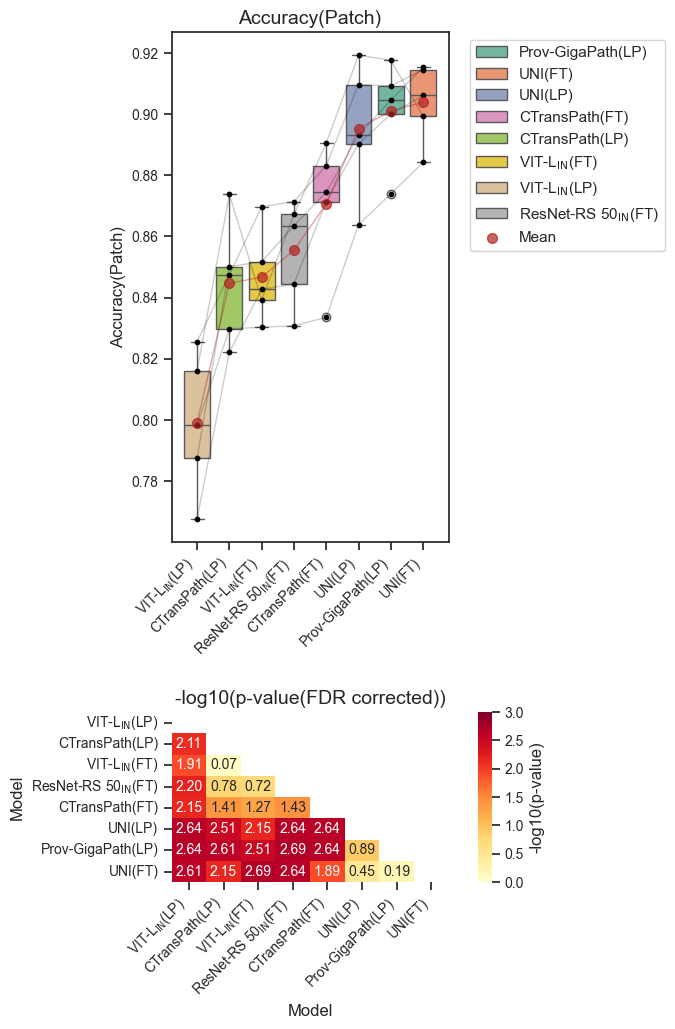

In [6]:
from statsmodels.stats.multitest import multipletests

label_order = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    r'VIT-L$\mathrm{_{IN}}$(FT)',
    r'VIT-L$\mathrm{_{IN}}$(LP)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
    # r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
]


def paired_box(target:Literal['cv', 'ebrains'], limit:int, key:str, title=None, verbose=False, excludes=['frozen_baseline-cnn']):
    df = pd.read_excel(f'out/figs/results_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

    for e in excludes:
        df = df[~df['cond'].str.startswith(e)]

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key].mean().sort_values(ascending=True)
    df[f'average_{key}'] = df['cond'].map(df_mean)
    df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
    
    labels = df['label'].unique()

    
    # Create figure with GridSpec
    fig = plt.figure(figsize=(8, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[3, 1], hspace=0.5, wspace=0.2)

    # Create axes
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[1, 1])

    # Box plot
    color_map = dict(zip((label_order), plt.cm.Set2(np.linspace(0, 1, len(label_order)))))
    sns.boxplot(x='label', hue='label', y=key, data=df, legend=True, palette=[color_map[label] for label in labels], ax=ax1)

    # Connect folds with lines
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax1.plot(range(n_models), fold_data[key], 'k-', alpha=0.2, linewidth=1)
    
    # Scatter individual points
    for i, label in enumerate(labels):
        ax1.scatter([i] * n_folds, df[df['label'] == label][key], color='black', s=10, zorder=3)
    
    # Plot mean
    ax1.plot(range(n_models), df_mean, 'firebrick', linewidth=1, zorder=4, alpha=0.4)
    mean_scatter = ax1.scatter(range(n_models), df_mean, color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    # Set ax1 properties
    ax1.set_title(key)
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.set_ylabel(key)


    # Calculate p-values
    p_values = []
    for i in range(n_models):
        for j in range(i+1, n_models):
            a = df[df['label']==labels[i]][key]
            b = df[df['label']==labels[j]][key]
            t_stat, p_value = stats.ttest_rel(a, b)
            p_values.append(p_value)

    # Benjamini-Hochberg correction
    _, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

    # Create significance matrix
    sig_matrix = np.zeros((n_models, n_models))
    k = 0
    for i in range(n_models):
        for j in range(i+1, n_models):
            sig_matrix[j, i] = -np.log10(p_corrected[k])
            k += 1

    # Create mask for lower triangle
    mask = np.triu(np.ones_like(sig_matrix, dtype=bool), k=0)

    # Heatmap
    heatmap = sns.heatmap(sig_matrix, mask=mask, annot=True, fmt='.2f', cmap='YlOrRd', 
                          ax=ax2, cbar_ax=cax, cbar_kws={'label': '-log10(p-value)'}, vmin=0.0, vmax=3.0)

    # Set ax2 properties
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_yticklabels(labels, rotation=0)
    ax2.set_title('-log10(p-value(FDR corrected))')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Model')

    # handles, labels = ax1.get_legend_handles_labels()
    # handles = handles[:-1][::-1] + [handles[-1]]
    # labels = labels[:-1][::-1] + [labels[-1]]
    # ax1.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    handles, labels = ax1.get_legend_handles_labels()
    legend_labels = label_order + ['Mean']
    legend_handles = []
    for i, l in enumerate(label_order):
        o = labels.index(l)
        legend_handles.append(handles[o])
    legend_handles += [mean_scatter]
    ax1.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplots_adjust(left=0.30, right=0.70, top=0.95, bottom=0.1)
    print(f'{target} - {limit} - {key}')


paired_box('cv', 100, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_cv_100_pacc.png", format="png", dpi=DPI)
plt.show()

### CV 100 patches/case

cv - 100 - Accuracy(Patch)


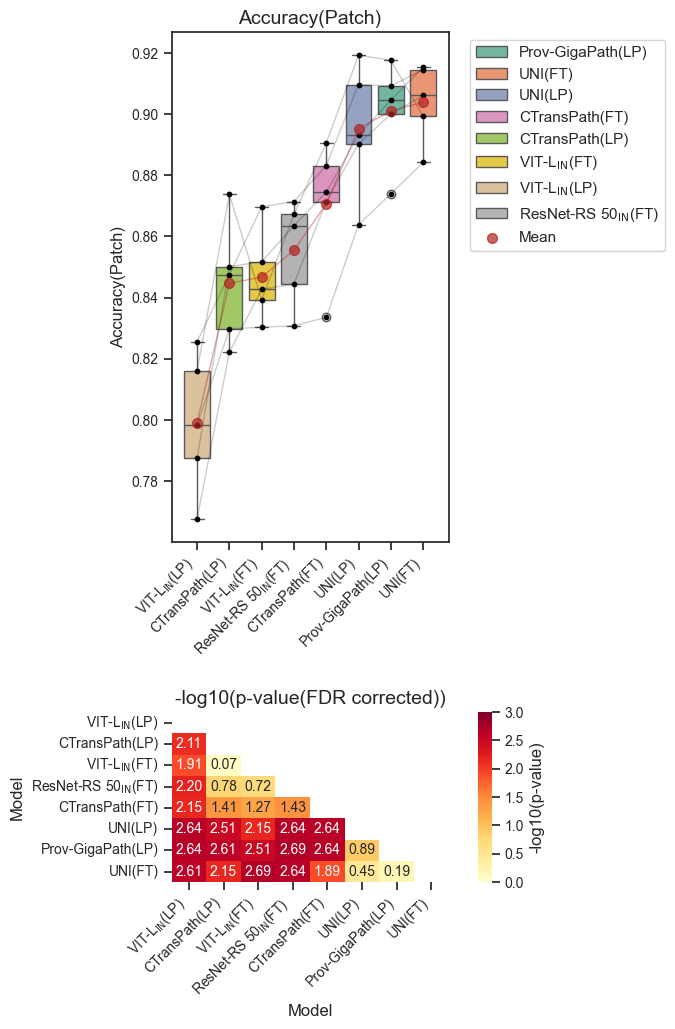

In [7]:
paired_box('cv', 100, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_cv_100_pacc.png", format="png", dpi=DPI)
plt.show()

cv - 100 - Accuracy


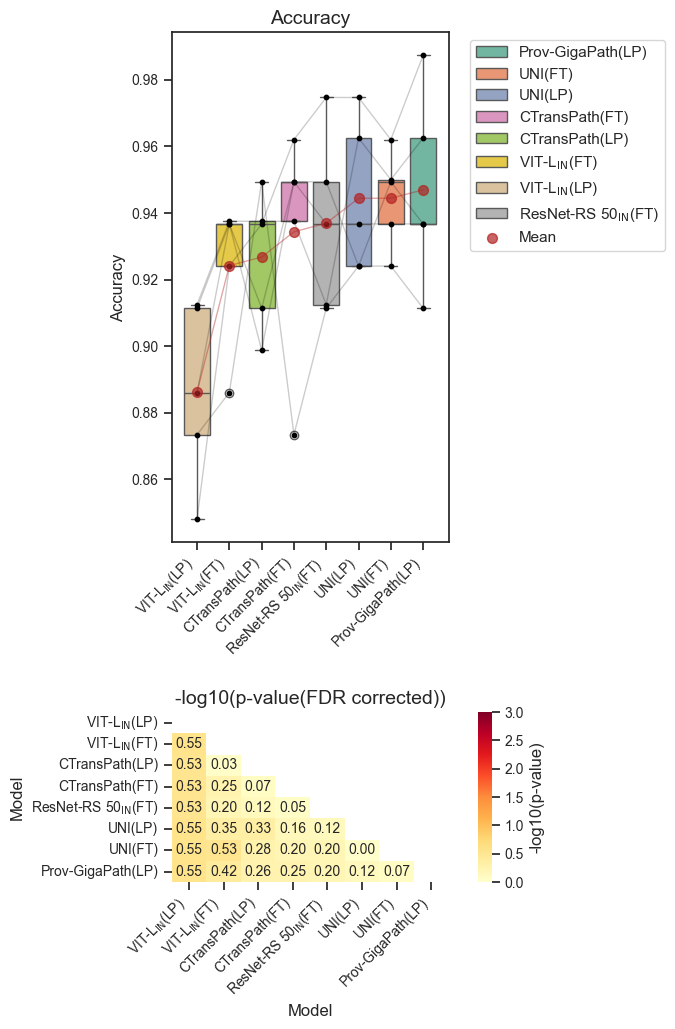

In [8]:
paired_box('cv', 100, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_cv_100_acc.png", format="png", dpi=300)
plt.show()

cv - 100 - F1 score


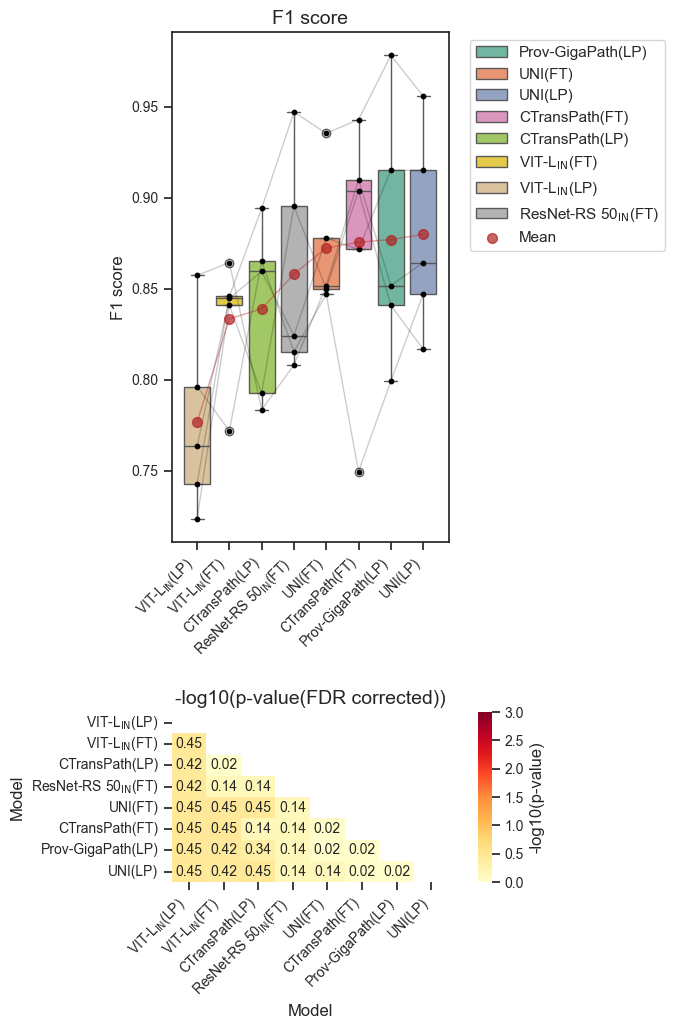

In [9]:
paired_box('cv', 100, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_cv_100_f1.png", format="png", dpi=DPI)

### EBRAINS 500 patches/case

ebrains - 500 - Accuracy(Patch)


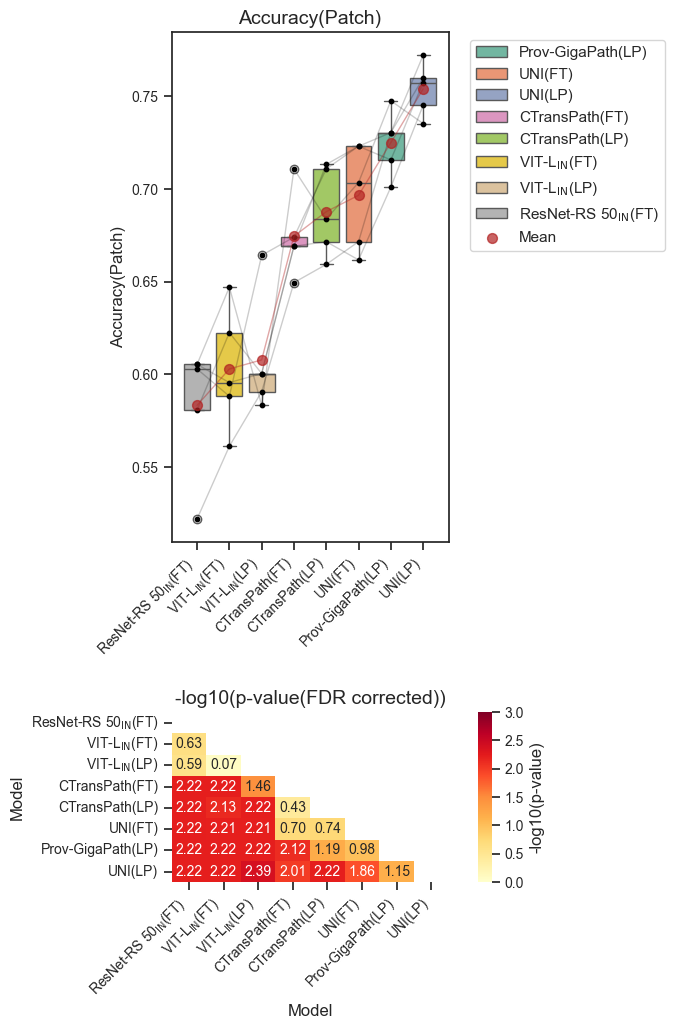

In [10]:
paired_box('ebrains', 500, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_ebrains_500_pacc.png", format="png", dpi=300)

ebrains - 500 - Accuracy


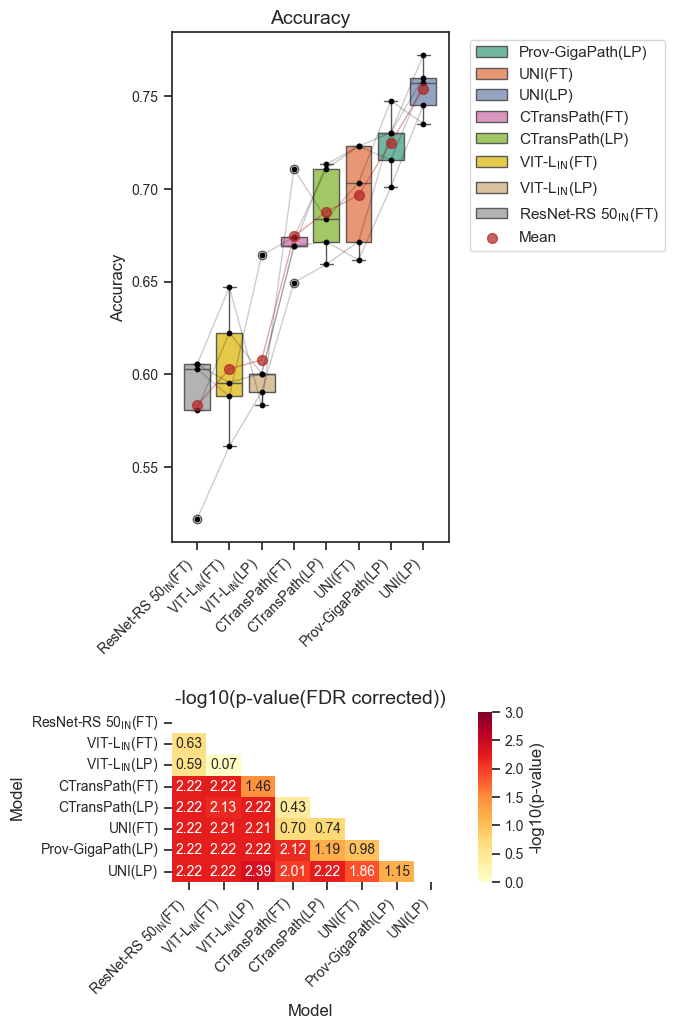

In [11]:
paired_box('ebrains', 500, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_500_acc.png", format="png", dpi=DPI)

### EBRAINS 100 patches/case

ebrains - 100 - Accuracy(Patch)


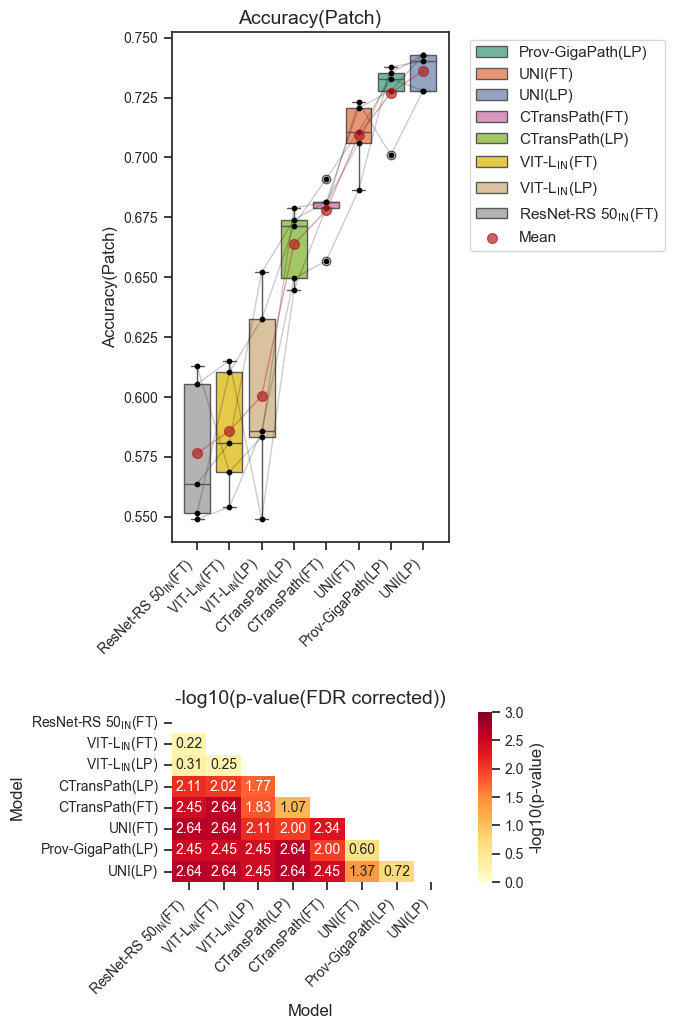

In [12]:
paired_box('ebrains', 100, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_ebrains_100_pacc.png", format="png", dpi=300)

ebrains - 100 - Accuracy


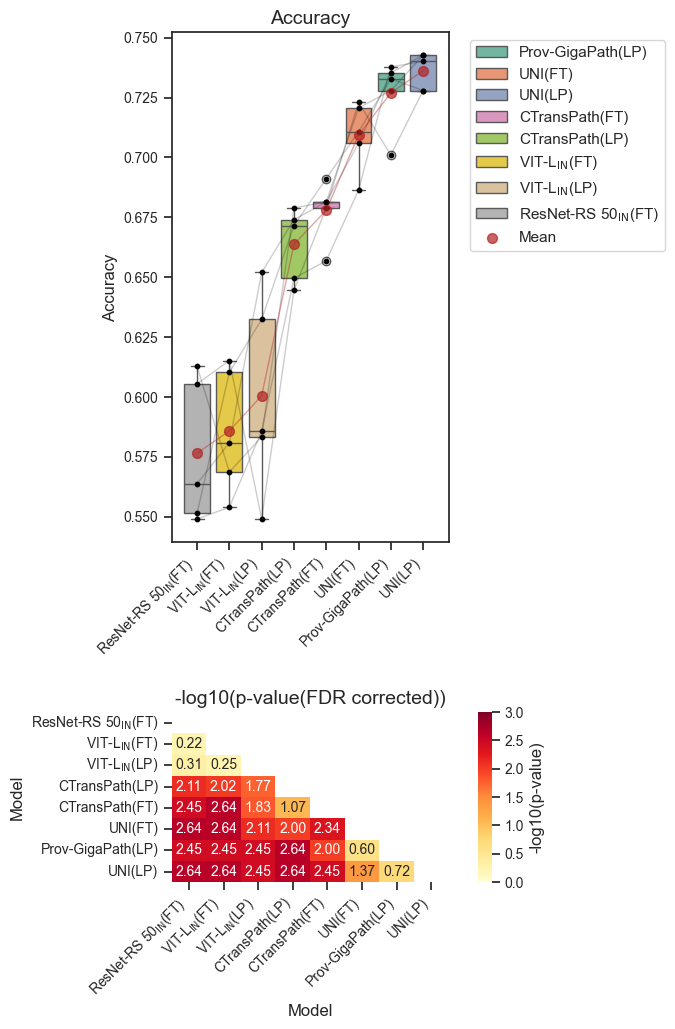

In [13]:
paired_box('ebrains', 100, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_100_acc.png", format="png", dpi=DPI)

ebrains - 100 - F1 score


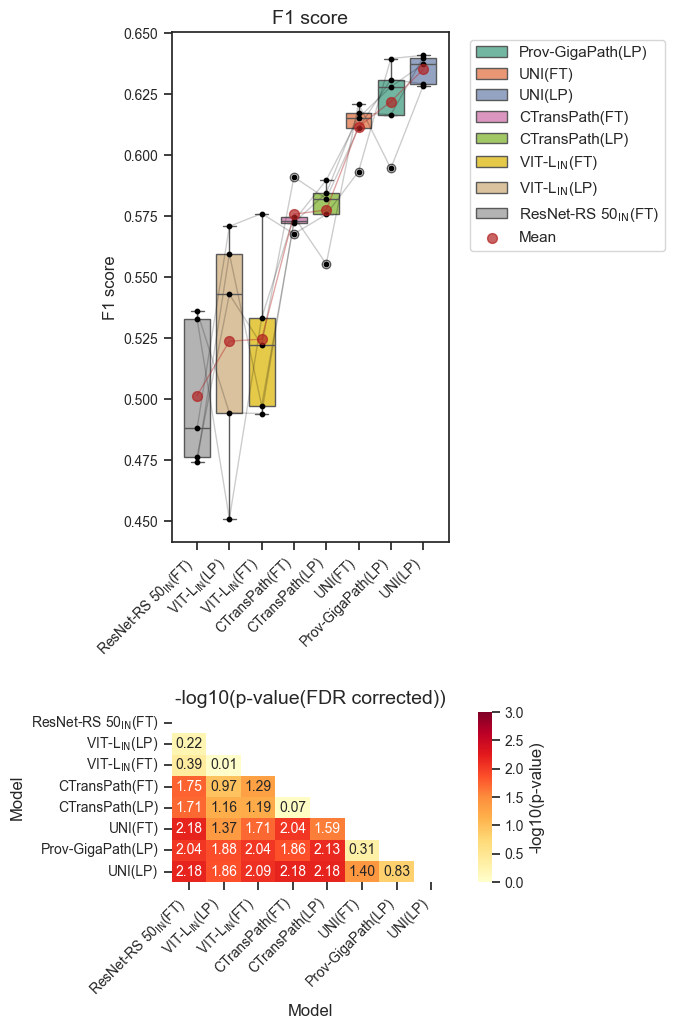

In [14]:
paired_box('ebrains', 100, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_f1.png", format="png", dpi=DPI)
plt.show()

ebrains - 10 - Accuracy(Patch)


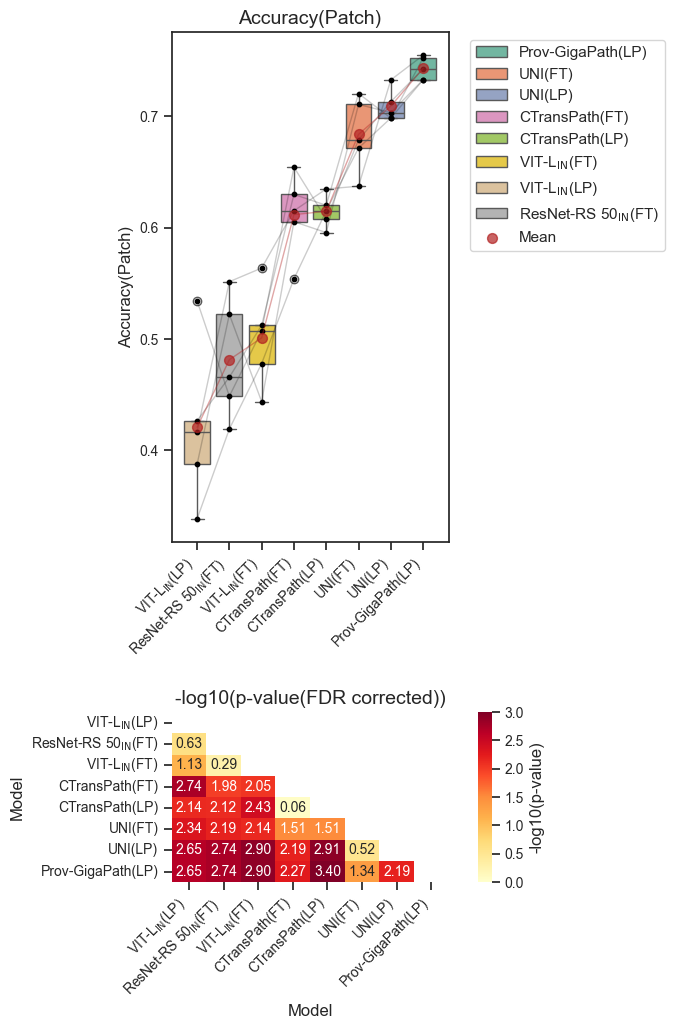

In [15]:
paired_box('ebrains', 10, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_pacc.png", format="png", dpi=DPI)

ebrains - 10 - Accuracy


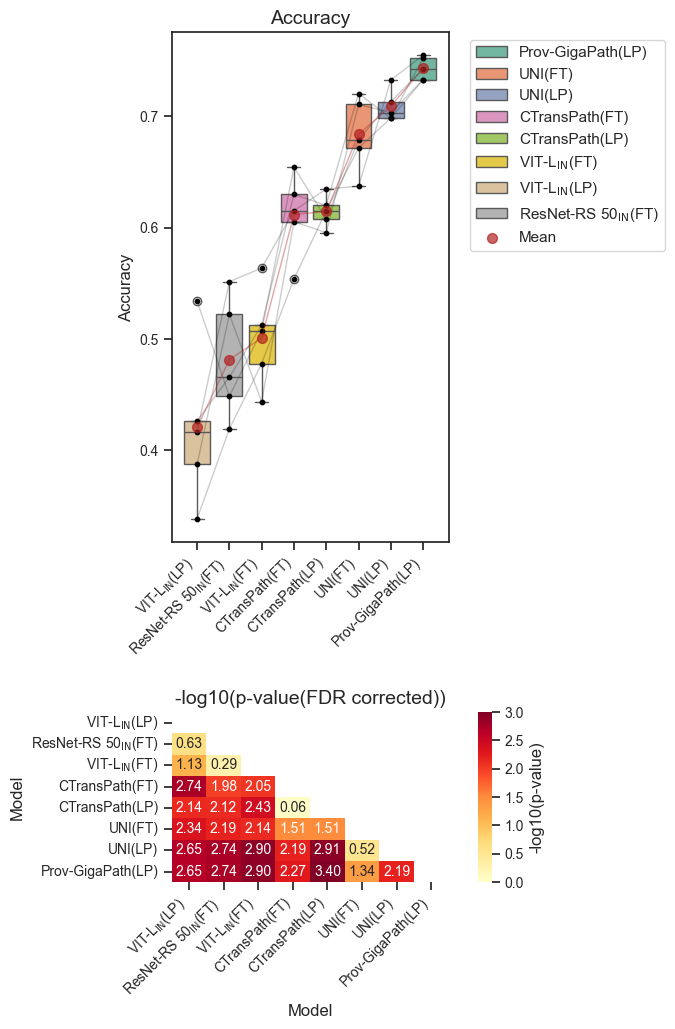

In [16]:
paired_box('ebrains', 10, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_acc.png", format="png", dpi=DPI)

ebrains - 10 - F1 score


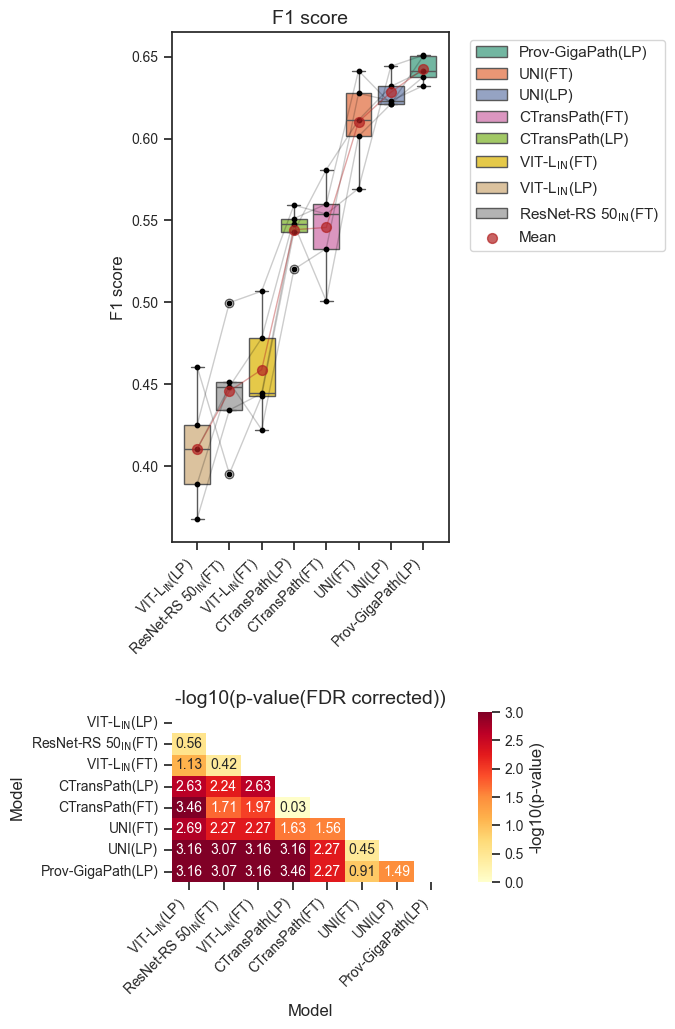

In [17]:
paired_box('ebrains', 10, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_f1.png", format="png", dpi=DPI)
plt.show()

#### fig4

This fig shows the impact of patch number per case on model performace

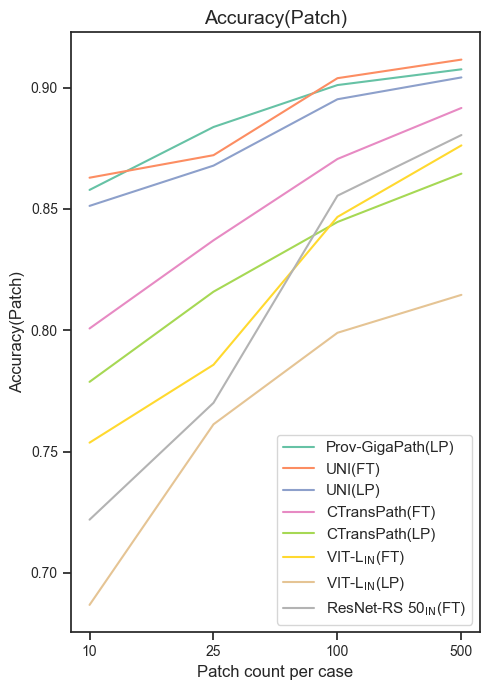

In [18]:

def draw_lines(target:Literal['cv', 'ebrains'], key:str, labels=None, fill=False):
    label_order = [
        'Prov-GigaPath(LP)',
        'UNI(FT)',
        'UNI(LP)',
        'CTransPath(FT)',
        'CTransPath(LP)',
        r'VIT-L$\mathrm{_{IN}}$(FT)',
        r'VIT-L$\mathrm{_{IN}}$(LP)',
        r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
        # r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    ]
    
    color_map = dict(zip((label_order), plt.cm.Set2(np.linspace(0, 1, len(label_order)))))
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel(f'out/figs/results_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

        if labels is None:
            if limit == limits[0]:
                # sort on 10 limit
                df_mean = df.groupby('label')[key].mean().sort_values(ascending=True)
                df[f'average_{key}'] = df['label'].map(df_mean)
                df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
                labels = df['label'].unique()[::-1]

        for label in labels:
            scores = df[df['label']==label][key]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            # CI
            # diff = stats.t.interval(1 - alpha, df=len(scores)-1, loc=mean, scale=diff)[1] - mean
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    plt.figure(figsize=(5, 7))
    x = np.arange(1, 1+len(limits))

    for i, label in enumerate(labels):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        # c = colors[i]
        c = color_map[label]
        plt.plot(x, values_by_cond[i, :, 0], color=c, label=label)
        if fill:
            plt.fill_between(x, ci_l, ci_h, color=c, alpha=0.1)
    
    plt.xticks(x, limits)
    plt.xlabel('Patch count per case')
    plt.ylabel(key)
    plt.legend(loc='lower right')
    plt.title(key)
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    return labels

labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    'VIT-L$\\mathrm{_{IN}}$(FT)',
    'VIT-L$\\mathrm{_{IN}}$(LP)',
    'ResNet-RS 50$\\mathrm{_{IN}}$(FT)',
    # 'ResNet-RS 50$\\mathrm{_{IN}}$(LP)',
]
draw_lines('cv', 'Accuracy(Patch)', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_pacc.png", format="png", dpi=DPI)
plt.show()

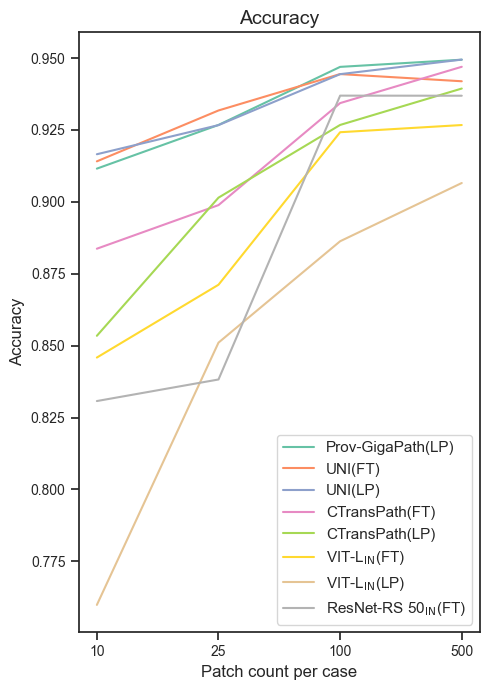

In [19]:
draw_lines('cv', 'Accuracy', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_acc.png", format="png", dpi=DPI)
plt.show()

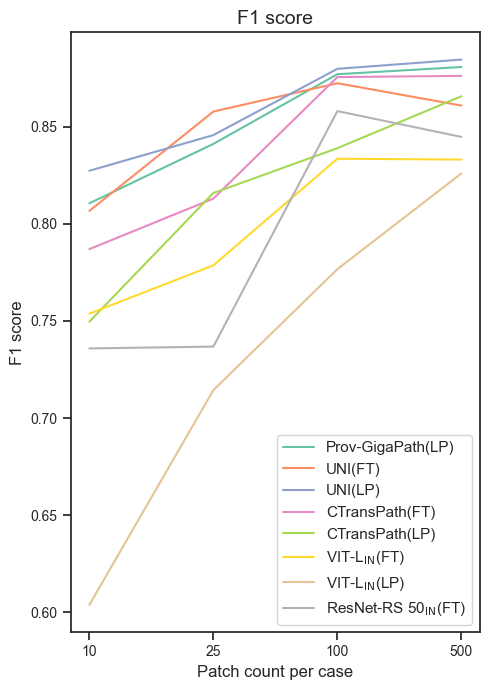

In [20]:
draw_lines('cv', 'F1 score', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_f1.png", format="png", dpi=DPI)
plt.show()

### Fig4: EBRAINS - lines

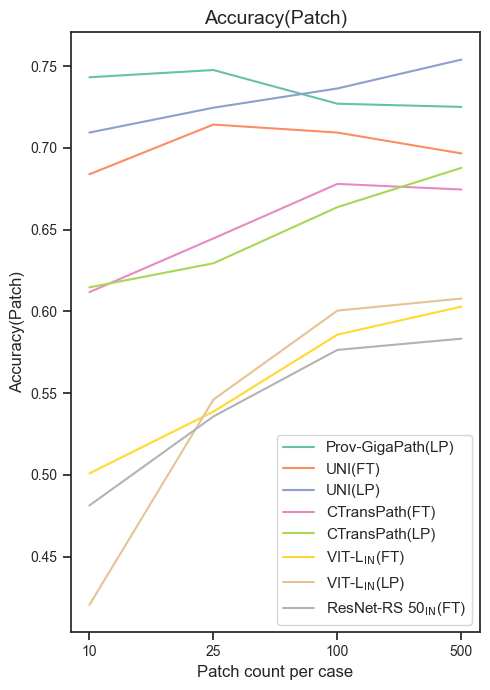

In [21]:
draw_lines('ebrains', 'Accuracy(Patch)', labels)
plt.savefig(f"out/figs/fig4_ebrains_pacc.png", format="png", dpi=DPI)
plt.show()

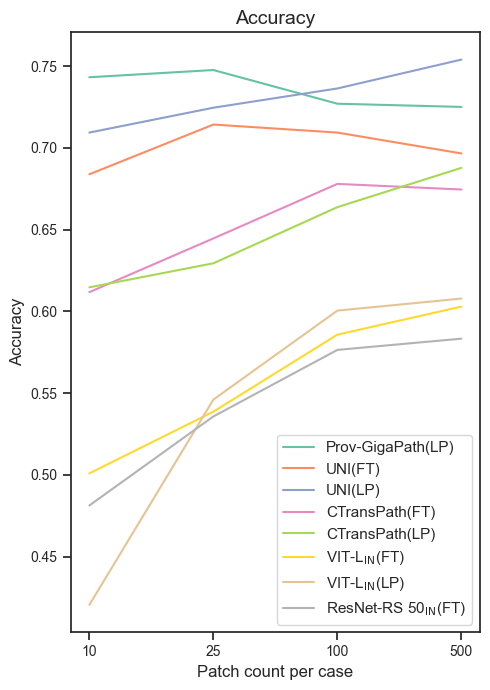

In [22]:
draw_lines('ebrains', 'Accuracy', labels)
plt.savefig(f"out/figs/fig4_ebrains_acc.png", format="png", dpi=DPI)
plt.show()

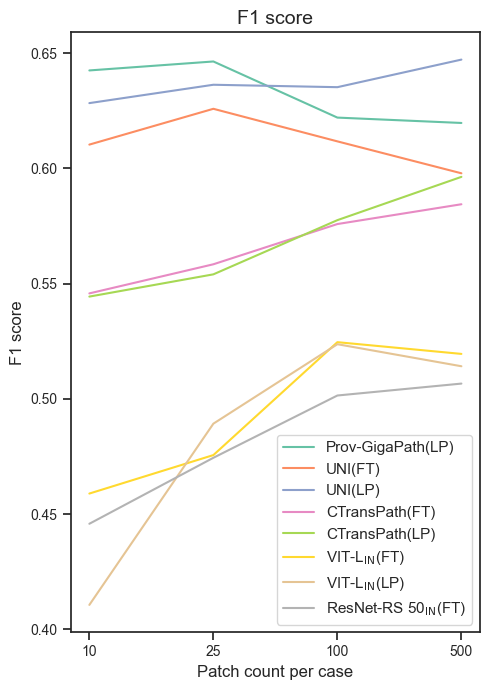

In [23]:
draw_lines('ebrains', 'F1 score', labels)
plt.savefig(f"out/figs/fig4_ebrains_f1.png", format="png", dpi=DPI)
plt.show()